# EEEN30101 Numerical Analysis

# Week 11

***&copy; 2023 Martínez Ceseña — University of Manchester, UK***

This notebook introduces the following topics:
- First order Ordinary Differential Equations (ODEs)
- Higher order systems

The use of the notebooks is optional and will not be marked. That said, you are strongly encouraged to play with the tools and examples, as you can explore different variations of the examples, which will better prepare you for the exams.

## List of contents

- [Analog simulation of first order ODEs](#Analog-simulation-of-first-order-ODEs)
  - [RC circuit analysis](#RC-circuit-analysis)
  - [RC circuit - Numerical analysis perspective](#RC-circuit---Numerical-analysis-perspective)
  - [General 1st order ODEs](#General-1st-order-ODEs)
- [Analog simulation of higher order systems](#Analog-simulation-of-higher-order-systems)
  - [Example of a second order ODE](#Example-of-a-second-order-ODE)
  - [General 2nd order ODEs](#General-2nd-order-ODEs)
- [Conclusion](#Conclusion)

## Before we begin

Before we begin: 
- Make sure to review the asynchronous materials provided in blackboard for EEEN30101 Week 11 
- If you have any questions, please post them in the discussion boards or, if that is not possible, send an email to alex.martinezcesena@manchester.ac.uk

This notebook provides some examples in python, for that purpose the following libraries will be loaded:

In [1]:
import schemdraw
import schemdraw.elements as elm
from schemdraw import dsp
import matplotlib.pyplot as plt  # To plot figures
import control
import numpy as np # To define and use matrices

# To create an interface to the code
import ipywidgets as widgets
from ipywidgets import interact

[Back to top](#EEEN30101-Numerical-Analysis)

## Analog simulation of first order ODEs

Analog simulation refers to the modelling of functions or signals that have continuous values. Unlike digital simulation, where the only specific samples are analysed due to the nature of the function or metering.

For example, your electricity consumption may be relatively continuous as you likely keep some devices connected at all time. However, your electricity bill is based on measurements taken every 30 minutes (if you have a smart meter) or less frequently. Therefore, even if your electricity use may be an analog signal, it is simulated (for the purpose of estimating your bill) as a discrete signal.

### RC circuit analysis

An example of analog simulations of ODEs, is the RC circuit presented below. Remember that ODEs are differential equations that only depend on a single independent variable.

The following ODE represents the RC circuit. 
- It is an ODE because it only depends on a single independent variable, i.e., time ($t$).
- It is a first order ODE because the highest derivative in the equation is a first order derivative.

$$I = C \frac{ \partial V_o}{\partial t}$$

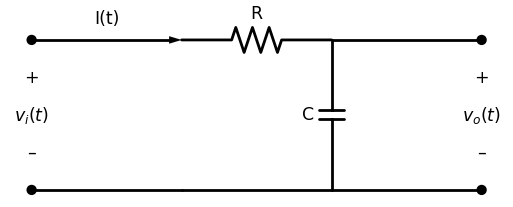

In [2]:
with schemdraw.Drawing() as d:
    d += elm.Dot()
    d += elm.Line(arrow='->').right().label('I(t)')
    d += elm.Resistor().right().label('R')
    d.push()
    d += elm.Line().right().dot()
    d.pop()
    d += elm.Capacitor().down().label('C')
    d.push()
    d += elm.Line().right().dot()
    d += elm.Gap().up().label(['–','$v_o(t)$','+'])
    d.pop()
    d += elm.Line().left()
    d += elm.Line().left().dot()
    d += elm.Gap().up().label(['–','$v_i(t)$','+'])

A description of ODEs, including applications to the RC circuit can be found in the video below.

In [3]:
%%HTML
<iframe width="560" height="315" 
src="https://www.youtube.com/embed/owGqLy1ibeo?si=kxSiM9ZO2XpJP6w2" 
title="YouTube video player"
frameborder="0" allow="accelerometer;
autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture;
web-share" allowfullscreen></iframe>

The ODE or the RC system captures the fact that there will only be current across the circuit when the voltage is changing. The magnitude of this current will increase with:
- A higher rate of change of the voltage or 
- A higher capacitance

Let us explore this further.

The voltage across the resistor, can be calculated as $IR$ and also corresponds to the difference between the input and output voltages ($V_i - V_o$).

$$IR = V_i - V_o$$

If we replace the current ($I$) with its corresponding ODE, we get the following equation:

$$RC \frac{ \partial V_o}{\partial t}  = V_i - V_o $$

$$ \frac{\partial V_o}{\partial t} + \frac{1}{CR}V_o = \frac{1}{CR}Vi$$

[Back to top](#EEEN30101-Numerical-Analysis)

This new equations allows us to explore the interdependencies between the input voltage ($V_i$) and output voltage ($V_o$) of the RC circuit. However, we need to select an approach to solve the ODE.

Taking a signals and systems point of view, we can use the Laplace transform to convert this equation to:

$$ s V_o(s) + \frac{1}{CR} V_o(s) = \frac{1}{CR}V_i(s)$$

$$ V_o(s) = \frac{1}{CRs+1} V_i(s)$$

We can now explore the behaviour of the RC systems subject to different input voltages.

For example, we can explore what happens to $V_o$ when $V_i$ is a step function.

$$
V_i(t) =
\left\{ 
  \begin{array}{ c l }
    0 & \quad \textrm{when} \; t \leq 0 \\
    1 & \quad \textrm{when} \; t > 0
  \end{array}
\right.$$

In Laplace terms, our step voltage function ($V_i$) is denoted by:

$$V_i(s) = \frac{1}{s}$$

Therefore, the output voltage function becomes:

$$ V_o(s) = \frac{1}{CRs+1} \frac{1}{s}$$

The equation can be developed as follows:
$$
\begin{aligned}
  V_o(s) & = \frac{1}{(CRs+1)s} \\
  & = \frac{CRs + 1 - CRs}{(CRs+1)s} \\
  & = \frac{CRs+1}{(CRs+1)s}-\frac{CRs}{(CRs+1)s} \\
  & = \frac{1}{s}-\frac{CR}{CRs+1} \\
  & = \frac{1}{s}-\frac{1}{s+\frac{1}{CR}}
\end{aligned}
$$

Finally consider the following Laplace transforms:

$$ \mathcal{L}(1) = \frac{1}{s} $$

$$ \mathcal{L}(e^{at}) = \frac{1}{s-a} $$

Using the above Laplace transforms, we get:

$$ \mathcal{L}^{-1} \left( \frac{1}{s}-\frac{1}{s+\frac{1}{CR}} \right) = 1 - e^{-\frac{1}{CR}} $$

$$ V_o(t) = 1-e^{-\frac{t}{CR}}$$

We can simulate this result with the method presented below:

In [4]:
def plotRC(R, C):
    CR = R*C
    t = np.linspace(0, 20, 1000)
    Vi = np.ones(1000)
    Vi[0] = 0
    Vo = 1 - np.exp(-t/CR)

    fig, ax = plt.subplots()
    ax.plot(t, Vi, label='Vi')
    ax.plot(t, Vo, label='Vo')
    ax.set(xlabel='time (t)', ylabel='Voltage')
    ax.grid()
    plt.legend()
    plt.show()

@interact
def TestRCplot(R = widgets.FloatSlider(min=0.1, max = 2, value=1, description='R: ', continuous_update=False),
               C = widgets.FloatSlider(min=0.1, max = 2, value=1, description='C: ', continuous_update=False)):
    plotRC(R, C)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='R: ', max=2.0, min=0.1), Fl…

[Back to top](#EEEN30101-Numerical-Analysis)

### RC circuit - Numerical analysis perspective

From a numerical analysis perspective, we can represent our equation  (presented below) using a block diagram.

$$ \frac{\partial V_o}{\partial t} + \frac{1}{CR}V_o = \frac{1}{CR}Vi$$

However, if it is not evident how to develop the block diagram, we can build it step-by-step.

For this purpose, it is convenient to rewrite the equation so that $V_i$ and $V_o$ (input and output) are on one side of the equation (excluding the differential) as follows:

$$V_i - V_o = RC \frac{ \partial V_o}{\partial t}$$

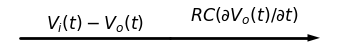

In [5]:
with schemdraw.Drawing() as d:
    d += elm.Line().right().length(d.unit).label('$V_i(t) - V_o(t)$')
    d += elm.Line(arrow='->').right().length(d.unit).label('$RC(\partial V_o(t)/ \partial t)$')

We rewrite the equation by moving $RC$ to the left side of the equation:

$$(V_i - V_o) \frac{1}{RC} = \frac{ \partial V_o}{\partial t}$$

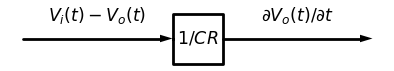

In [6]:
with schemdraw.Drawing() as d:
    d += elm.Line(arrow='->').right().length(d.unit).label('$V_i(t) - V_o(t)$')
    d += dsp.Square().label('$1/CR$')
    d += elm.Line(arrow='->').right().length(d.unit).label('$\partial V_o(t)/ \partial t$')

The next step would be to integrate the differential equation to get:

$$\int \frac{V_i - V_o}{RC} dt = V_o$$

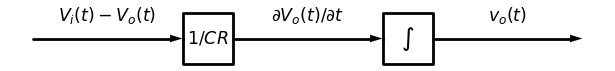

In [7]:
with schemdraw.Drawing() as d:
    d += elm.Line(arrow='->').right().length(d.unit).label('$V_i(t) - V_o(t)$')
    d += dsp.Square().label('$1/CR$')
    d += elm.Line(arrow='->').right().length(d.unit).label('$\partial V_o(t)/ \partial t$')
    d += dsp.Square().label('$\int$')
    d += elm.Line(arrow='->').right().length(d.unit).label('$v_o(t)$')

We finally introduce a feedback loop to finalise the block diagram:

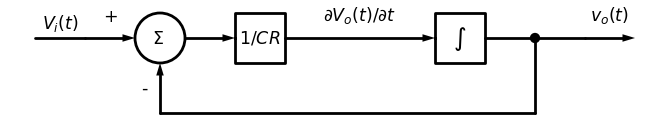

In [8]:
with schemdraw.Drawing() as d:
    d += elm.Line().right().length(d.unit/3).label('$V_i(t)$')
    d += elm.Line(arrow='->').right().length(d.unit/3).label('+')
    d += dsp.SumSigma()
    d += elm.Line(arrow='->').right().length(d.unit/3)
    d += dsp.Square().label('$1/CR$')
    d += elm.Line(arrow='->').right().label('$\partial V_o(t)/ \partial t$')
    d += dsp.Square().label('$\int$')
    d += elm.Line().right().length(d.unit/3)
    d += elm.Dot()
    d.push()
    d += elm.Line().right().length(d.unit/3)
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$v_o(t)$')
    d.pop()
    d += elm.Line().down().length(d.unit/2)
    d += elm.Line().left().length(d.unit*2.5)
    d += elm.Line(arrow='->').up().length(d.unit/3).label('-')

We can validate or block diagram using relevant software, such as MATLAB's simulink or python's control library. Remember that, in the Laplace domain, $\int = 1/s$

In [9]:
def plot_control(y, t):
    plt.figure(figsize=(7,3))
    plt.plot(t, y)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.grid()
    plt.show()

@interact
def TestRCplot(R = widgets.FloatSlider(min=0.1, max = 2, value=1, description='R: ', continuous_update=False),
               C = widgets.FloatSlider(min=0.1, max = 2, value=1, description='C: ', continuous_update=False)):
    t = np.linspace(0,20,1000)
    Vi = np.ones(1000)
    Vi[0] = 0

    blockRC = control.tf([1/C/R], [1])  # 1/(CR)
    blockInt = control.tf([1], [1, 0])  # 1/s
    sys = control.feedback(blockRC*blockInt, 1)

    t, Vo = control.forced_response(sys, t, Vi)
    plot_control(Vo, t)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='R: ', max=2.0, min=0.1), Fl…

[Back to top](#EEEN30101-Numerical-Analysis)

### General 1st order ODEs

Consider the following block diagram, which represents a general 1st order linear ODE.

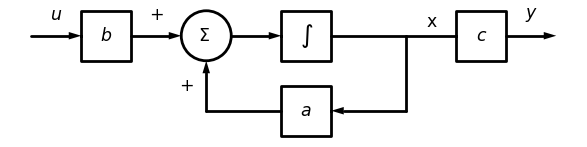

In [10]:
with schemdraw.Drawing() as d:
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$u$')
    d += dsp.Square().label('$b$')
    d += elm.Line(arrow='->').right().length(d.unit/3).label('+')
    d += dsp.SumSigma()
    d += elm.Line(arrow='->').right().length(d.unit/3)
    d += dsp.Square().label('$\int$')
    d += elm.Line().right().length(d.unit/2)
    d.push()
    d += elm.Line().right().length(d.unit/3).label('x')
    d += dsp.Square().label('$c$')
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$y$')
    d.pop()
    d += elm.Line().down().length(d.unit/2)
    d += elm.Line(arrow='->').left().length(d.unit/2)
    d += dsp.Square().label('$a$')
    d += elm.Line().left().length(d.unit/2)
    d += elm.Line(arrow='->').up().length(d.unit/3).label('+')

The state space realisation associated with the block diagram is as follows:

$$ \frac{\partial x}{\partial t} = ax +bu$$

$$y = cx$$

Note that, in this example, we only have a single state: $x(t)$

The corresponding ODE is:

$$ \frac{\partial y}{\partial t} = C \frac{\partial x}{\partial t} - cax + cbu = ay + cbu$$

The corresponding transfer function is:

$$ Y(s) = \frac{1}{s-a}cbu(s)$$

Be aware that this representation is not unique.

[Back to top](#EEEN30101-Numerical-Analysis)

## Analog simulation of higher order systems

### Example of a second order ODE

As an example of higher order systems, consider the following RLC system.

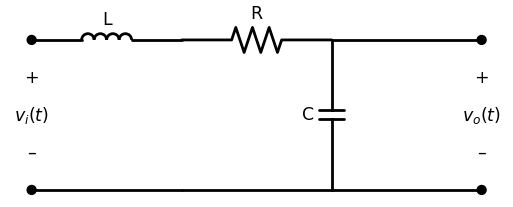

In [11]:
with schemdraw.Drawing() as d:
    d += elm.Dot()
    d += elm.Inductor().right().label('L')
    d += elm.Resistor().right().label('R')
    d.push()
    d += elm.Line().right().dot()
    d.pop()
    d += elm.Capacitor().down().label('C')
    d.push()
    d += elm.Line().right().dot()
    d += elm.Gap().up().label(['–','$v_o(t)$','+'])
    d.pop()
    d += elm.Line().left()
    d += elm.Line().left().dot()
    d += elm.Gap().up().label(['–','$v_i(t)$','+'])

The system can be modelled with the following second order differential equation:

$$ \frac{\partial^2 V_o}{\partial t^2} + \frac{R}{L} \frac{\partial V_0}{\partial t} + \frac{1}{LC}V_o = \frac{1}{LC} V_i$$

As this is a second order equation, we need two states (e.g., $x_1$ and $x_2$)

$$x_1 = V_o$$

$$ x_2 = \frac{\partial x_1}{\partial t}$$

Accordingly, we get:

$$ \frac{\partial x_2}{\partial t} + \frac{R}{L} x_2 + \frac{1}{LC}x_1 = \frac{1}{LC} V_i$$


The realisation of this equation is presented below:

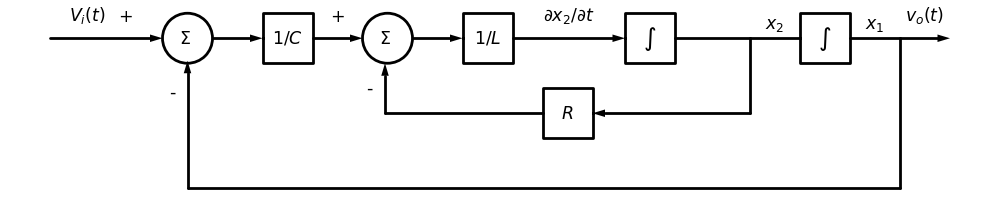

In [12]:
with schemdraw.Drawing() as d:
    d += elm.Line(arrow='->').right().length(d.unit*3/4).label(['$V_i(t)$','+'])
    d += dsp.SumSigma()
    d += elm.Line(arrow='->').right().length(d.unit/3)
    d += dsp.Square().label('$1/C$')
    d += elm.Line(arrow='->').right().length(d.unit/3).label('+')
    d += dsp.SumSigma()
    d += elm.Line(arrow='->').right().length(d.unit/3)
    d += dsp.Square().label('$1/L$')
    d += elm.Line(arrow='->').right().length(d.unit*3/4).label('$\partial x_2/\partial t$')
    d += dsp.Square().label('$\int$')
    d += elm.Line().right().length(d.unit/2)
    d.push()
    d += elm.Line().down().length(d.unit/2)
    d += elm.Line(arrow='->').left().length(d.unit*1.05)
    d += dsp.Square().label('$R$')
    d += elm.Line().left().length(d.unit*1.05)
    d += elm.Line(arrow='->').up().length(d.unit/3).label('-')
    d.pop()
    d += elm.Line().right().length(d.unit/3).label('$x_2$')
    d += dsp.Square().label('$\int$')
    d += elm.Line().right().length(d.unit/3).label('$x_1$')
    d.push()
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$v_o(t)$')
    d.pop()
    d += elm.Line().down()
    d += elm.Line().left().length(d.unit*4.75)
    d += elm.Line(arrow='->').up().length(d.unit*.85).label(['', '', '-'])

[Back to top](#EEEN30101-Numerical-Analysis)

The block diagram bring together all the equations presented above, to be more specific:

$$ \frac{\partial x_1}{\partial t} = x_2$$

$$ \frac{\partial}{\partial t} [x_1] = \left[ \begin{array}{cc}0 & 1\end{array} \right] \left[ \begin{array}{c}x_1 \\ x_2\end{array} \right] $$

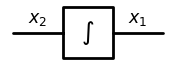

In [13]:
with schemdraw.Drawing() as d:
    d += elm.Line().right().length(d.unit/3).label('$x_2$')
    d += dsp.Square().label('$\int$')
    d += elm.Line().right().length(d.unit/3).label('$x_1$')

$$V_o = x_1$$

$$V_o = \left[ \begin{array}{cc}1 & 0\end{array} \right] \left[ \begin{array}{c}x_1 \\ x_2\end{array} \right] $$

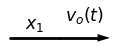

In [14]:
with schemdraw.Drawing() as d:
    d += elm.Line().right().length(d.unit/3).label('$x_1$')
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$v_o(t)$')

$$ \frac{\partial x_2}{\partial t} = \left[ (V_i - x_1) \frac{1}{C} - Rx_2\right] \frac{1}{L}$$

$$\frac{\partial}{\partial t} [x_2] = \left[ \begin{array}{cc} -\frac{1}{LC} & -\frac{R}{L} \end{array} \right] \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] + \left[ \begin{array}{c} 0 \\ \frac{1}{LC} \end{array} \right] V_i(t)$$

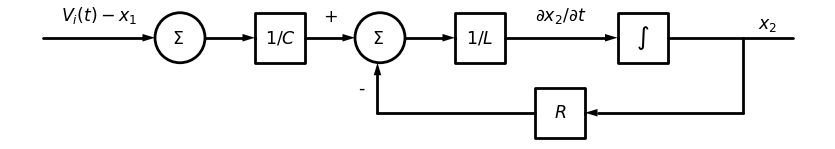

In [15]:
with schemdraw.Drawing() as d:
    d += elm.Line(arrow='->').right().length(d.unit*3/4).label(['$V_i(t)-x_1$'])
    d += dsp.SumSigma()
    d += elm.Line(arrow='->').right().length(d.unit/3)
    d += dsp.Square().label('$1/C$')
    d += elm.Line(arrow='->').right().length(d.unit/3).label('+')
    d += dsp.SumSigma()
    d += elm.Line(arrow='->').right().length(d.unit/3)
    d += dsp.Square().label('$1/L$')
    d += elm.Line(arrow='->').right().length(d.unit*3/4).label('$\partial x_2/\partial t$')
    d += dsp.Square().label('$\int$')
    d += elm.Line().right().length(d.unit/2)
    d.push()
    d += elm.Line().down().length(d.unit/2)
    d += elm.Line(arrow='->').left().length(d.unit*1.05)
    d += dsp.Square().label('$R$')
    d += elm.Line().left().length(d.unit*1.05)
    d += elm.Line(arrow='->').up().length(d.unit/3).label('-')
    d.pop()
    d += elm.Line().right().length(d.unit/3).label('$x_2$')

The full notation in matrix form is as follows:

$$\frac{\partial}{\partial t} \left[ \begin{array}{c}x_1 \\ x_2\end{array} \right] = \left[ \begin{array}{cc} 0 & 1 \\ -\frac{1}{LC} & -\frac{R}{L} \end{array} \right] \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] + \left[ \begin{array}{c} 0 \\ \frac{1}{LC} \end{array} \right] V_i(t)$$

$$ V_o(t) = \left[ \begin{array}{cc}1 & 0\end{array} \right] \left[ \begin{array}{c}x_1 \\ x_2\end{array} \right]$$

The state space formulation is:

$$ \underline{x} = \left[ \begin{array}{c}x_1 \\ x_2\end{array} \right]$$

$$ \underline{\dot{x}} = A \underline{x} + Bu$$

$$y = C \underline{x}$$

A general second order ODE may take the following form:


$$ \frac{\partial^2y }{\partial t^2} + a_1\frac{\partial y}{\partial t} +a_0y = b_1 \frac{\partial u}{ \partial t} + b_0u$$

[Back to top](#EEEN30101-Numerical-Analysis)

### General 2nd order ODEs

There are multiple options to realise this ODE. An example realisation is presented below:

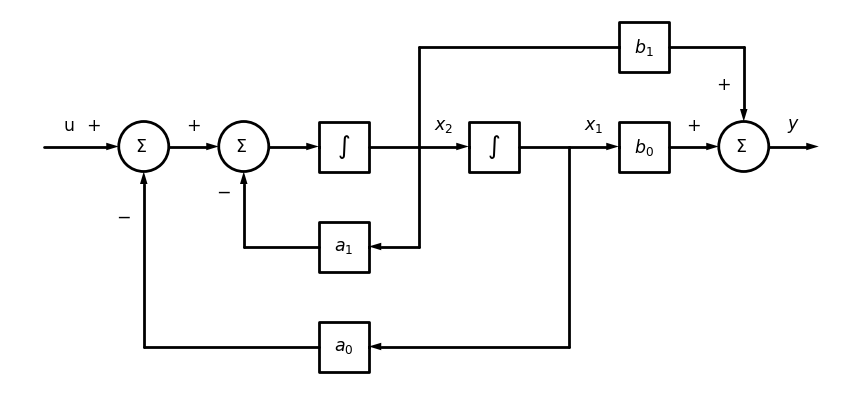

In [16]:
with schemdraw.Drawing() as d:
    d += elm.Line(arrow='->').right().length(d.unit/2).label(['u','+'])
    d += dsp.SumSigma()
    d += elm.Line(arrow='->').right().length(d.unit/3).label('+')
    d += dsp.SumSigma()
    d += elm.Line(arrow='->').right().length(d.unit/3)
    d += dsp.Square().label('$\int$')
    d += elm.Line().right().length(d.unit/3)
    d.push()
    d += elm.Line().down().length(d.unit*2/3)
    d += elm.Line(arrow='->').left().length(d.unit/3)
    d += dsp.Square().label('$a_1$')
    d += elm.Line().left().length(d.unit/2)
    d += elm.Line(arrow='->').up().length(d.unit/2).label(['', '', '$-$'])
    d.pop()
    d.push()
    d += elm.Line().up().length(d.unit*2/3)
    d += elm.Line().right().length(d.unit*(1+1/3))
    d += dsp.Square().label('$b_1$')
    d += elm.Line().right().length(d.unit/2)
    d += elm.Line(arrow='->').down().length(d.unit/2).label('+')
    d.pop()
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$x_2$')
    d += dsp.Square().label('$\int$')
    d += elm.Line().right().length(d.unit/3)
    d.push()
    d += elm.Line().down().length(d.unit*4/3)
    d += elm.Line(arrow='->').left().length(d.unit*(1+1/3))
    d += dsp.Square().label('$a_0$')
    d += elm.Line().left().length(d.unit*(1+1/6))
    d += elm.Line(arrow='->').up().length(d.unit*(1+1/6)).label(['', '', '$-$'])
    d.pop()
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$x_1$')
    d += dsp.Square().label('$b_0$')
    d += elm.Line(arrow='->').right().length(d.unit/3).label('+')
    d += dsp.SumSigma()
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$y$')

Using standard matrix notation, we get:

$$\frac{\partial}{\partial t} \left[ \begin{array}{c}x_1 \\ x_2\end{array} \right] = \left[ \begin{array}{cc} 0 & 1 \\ -a_0 & -a_1 \end{array} \right] \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] + \left[ \begin{array}{c} 0 \\ 1 \end{array} \right] u$$

$$y = \left[ \begin{array}{cc}b_1 & b_0\end{array} \right] \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] $$

To obtain the corresponding transfer function, it is convenient to take the Laplace transform:


$$sX(s) = AX(s)+BU(s)$$

$$Y(s) = CX(s)$$

We can rearrange the equations as follows:

$$(sI - A)X(s) = BU(s)$$

and hence:

$$X(s) = (sI -A)^{-1} BU(s)$$

Substituting the results back in the previous equation, we get:

$$
\begin{aligned}
  Y(s)  & = \underbrace{C(sI-A)^{-1}B} & U(s)\\
   & \quad \quad \; P(s) & 
\end{aligned}
$$

In this case:

$$ A = \left[ \begin{array}{cc} 0 & 1 \\ -a_0 & -a_1 \end{array} \right] $$

$$ B = \left[ \begin{array}{c} 0 \\ 1 \end{array} \right] $$

$$C = \left[ \begin{array}{cc} b_1 & b_0 \end{array} \right] $$

Remember the general procedure to invert a 2x2 matrix:

$$ \left[ \begin{array}{cc} a & b \\ c & d \end{array} \right]^{-1} = \frac{1}{ad-bc}\left[ \begin{array}{cc} d & -b \\ -c & a \end{array} \right]$$

Accordingly, the transfer function is:

$$
\begin{aligned}
  P(s) & = C(sI-A)^{-1}B\\
  & = \left[ \begin{array}{cc} b_1 & b_0 \end{array} \right] \left[ \begin{array}{cc} 0 & 1 \\ a_0 & s+a_1 \end{array} \right]^{-1} \left[ \begin{array}{c} 0 \\ 1 \end{array} \right] \\
  & = \left[ \begin{array}{cc} b_1 & b_0 \end{array} \right] \frac{1}{s^2+a_1s+a_0}\left[ \begin{array}{cc} s+a_1 & 1 \\ a_0 & s \end{array} \right] \left[ \begin{array}{c} 0 \\ 1 \end{array} \right] \\
  & = \frac{1}{s^2+a_1s+a_0}\left[ \begin{array}{cc} b_1 & b_0 \end{array} \right] \left[ \begin{array}{c} 1 \\ s \end{array} \right] \\
  & = \frac{b_1s+b_0}{s^2+a_1s+a_0}
\end{aligned}
$$

Hence:
$$P(s) (s^2+a_1s+a_0) = b_1s+b_0$$


$$ \frac{\partial ^2y}{\partial t^2} + a_1 \frac{\partial y}{\partial t} + a_0y = b_1 \frac{\partial u}{\partial t}+b_0u$$


We can generalise this kind of realisation in different manners:
1. higher order differential equations
    - the number of integration blocks corresponds to the order of the differential equations
    - the number of states correspond to the order of the differential equations

2. Multivariable system (e.g., $m$ outputs and $n$ inputs)

$$ \underline{y}(t) = \left[ \begin{array}{c} y_1(t) \\ \vdots \\ y_m(t) \end{array} \right]$$

$$ \underline{u}(t) = \left[ \begin{array}{c} u_1(t) \\ \vdots \\ u_n(t) \end{array} \right]$$



3. Nonlinear systems

$$ \frac{\partial}{\partial t} x = f(x, u) $$

$$ y=g(x) $$

The implementation of the nonlinear systems may look as follows:

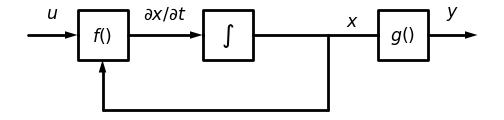

In [17]:
with schemdraw.Drawing() as d:
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$u$')
    d += dsp.Square().label('$f()$')
    d += elm.Line(arrow='->').right().length(d.unit/2).label('$\partial x / \partial t$')
    d += dsp.Square().label('$\int$')
    d += elm.Line().right().length(d.unit/2)
    d.push()
    d += elm.Line().right().length(d.unit/3).label('$x$')
    d += dsp.Square().label('$g()$')
    d += elm.Line(arrow='->').right().length(d.unit/3).label('$y$')
    d.pop()
    d += elm.Line().down().length(d.unit/2)
    d += elm.Line().left().length(d.unit*1.5)
    d += elm.Line(arrow='->').up().length(d.unit/3)

[Back to top](#EEEN30101-Numerical-Analysis)

## Conclusion

At the end of this week's lecture and after going through this notebook, you should be able to address the following questions:<br/>
- What are first order ODEs?<br/>
- What are higher order ODEs?<br/>
- How do you sketch the realisation of an ODE?<br/>
- How do you define the state space equation associated with an ODE?<br/>
- How do you develop the transfer function associated with an ODE?<br/><br/>

If you cannot answer these questions, you may want to check again this notebook and the lecture notes.

[Back to top](#EEEN30101-Numerical-Analysis)